The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0


# What Is Hyperparameter Optimization?
:label:`sec_what_is_hpo`

As we have seen in the previous chapters, deep neural networks come with a
large number of parameters or weights that are learned during training. On
top of these, every neural network has additional *hyperparameters* that need
to be configured by the user. For example, to ensure that stochastic gradient
descent converges to a local optimum of the training loss
(see :numref:`chap_optimization`), we have to adjust the learning rate and batch
size. To avoid overfitting on training datasets,
we might have to set regularization parameters, such as weight decay
(see :numref:`sec_weight_decay`) or dropout (see :numref:`sec_dropout`). We can
define the capacity and inductive bias of the model by setting the number of
layers and number of units or filters per layer (i.e., the effective number
of weights).

Unfortunately, we cannot simply adjust these hyperparameters by minimizing the
training loss, because this would lead to overfitting on the training data. For
example, setting regularization parameters, such as dropout or weight decay
to zero leads to a small training loss, but might hurt the generalization
performance.

![Typical workflow in machine learning that consists of training the model multiple times with different hyperparameters.](http://d2l.ai/_images/ml_workflow.svg)
:label:`ml_workflow`

Without a different form of automation, hyperparameters have to be set manually
in a trial-and-error fashion, in what amounts to a time-consuming and difficult
part of machine learning workflows. For example, consider training
a ResNet (see :numref:`sec_resnet`) on CIFAR-10, which requires more than 2 hours
on an Amazon Elastic Cloud Compute (EC2) `g4dn.xlarge` instance. Even just
trying ten hyperparameter configurations in sequence, this would already take us
roughly one day. To make matters worse, hyperparameters are usually not directly
transferable across architectures and datasets
:cite:`feurer-arxiv22,wistuba-ml18,bardenet-icml13a`, and need to be re-optimized
for every new task. Also, for most hyperparameters, there are no rule-of-thumbs,
and expert knowledge is required to find sensible values.

*Hyperparameter optimization (HPO)* algorithms are designed to tackle this
problem in a principled and automated fashion :cite:`feurer-automlbook18a`, by
framing it as a global optimization problem. The default objective is the error
on a hold-out validation dataset, but could in principle be any other business
metric. It can be combined with or constrained by secondary objectives, such as
training time, inference time, or model complexity. 

Recently, hyperparameter optimization has been extended to *neural architecture
search (NAS)* :cite:`elsken-arxiv18a,wistuba-arxiv19`, where the goal is to find
entirely new neural network architectures. Compared to classical HPO, NAS is even
more expensive in terms of computation and requires additional efforts to remain
feasible in practice. Both, HPO and NAS can be considered as sub-fields of 
AutoML :cite:`hutter-book19a`, which aims to automate the entire ML pipeline.

In this section we will introduce HPO and show how we can automatically find
the best hyperparameters of the logistic regression example introduced in
:numref:`sec_softmax_concise`.

##  The Optimization Problem
:label:`sec_definition_hpo`

We will start with a simple toy problem: searching for the learning rate of the
multi-class logistic regression model `SoftmaxRegression` from
:numref:`sec_softmax_concise` to minimize the validation error on the Fashion
MNIST dataset. While other hyperparameters like batch size or number of epochs
are also worth tuning, we focus on learning rate alone for simplicity.


In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn
from d2l import torch as d2l

Before we can run HPO, we first need to define two ingredients: the objective
function and the configuration space.

### The Objective Function

The performance of a learning algorithm can be seen as a function
$f: \mathcal{X} \rightarrow \mathbb{R}$ that maps from the hyperparameter space
$\mathbf{x} \in \mathcal{X}$ to the validation loss. For every evaluation of
$f(\mathbf{x})$, we have to train and validate our machine learning model, which
can be time and compute intensive in the case of deep neural networks trained on
large datasets. Given our criterion $f(\mathbf{x})$ our goal is to find
$\mathbf{x}_{\star} \in \mathrm{argmin}_{\mathbf{x} \in \mathcal{X}} f(\mathbf{x})$. 

There is no simple way to compute gradients of $f$ with respect to $\mathbf{x}$,
because it would require to propagate the gradient through the entire training
process. While there is recent work :cite:`maclaurin-icml15,franceschi-icml17a`
to drive HPO by approximate "hypergradients", none of the existing approaches
are competitive with the state-of-the-art yet, and we will not discuss them
here. Furthermore, the computational burden of evaluating $f$ requires HPO
algorithms to approach the global optimum with as few samples as possible.

The training of neural networks is stochastic (e.g., weights are randomly
initialized, mini-batches are randomly sampled), so that our observations will
be noisy: $y \sim f(\mathbf{x}) + \epsilon$, where we usually assume that the
$\epsilon \sim N(0, \sigma)$ observation noise is Gaussian distributed.

Faced with all these challenges, we usually try to identify a small set of well
performing hyperparameter configurations quickly, instead of hitting the global
optima exactly. However, due to large computational demands of most neural
networks models, even this can take days or weeks of compute. We will explore
in :numref:`sec_mf_hpo` how we can speed-up the optimization process by either
distributing the search or using cheaper-to-evaluate approximations of the
objective function.

We begin with a method for computing the validation error of a model.


In [2]:
class HPOTrainer(d2l.Trainer):  #@save
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1 -  accuracy / val_batch_idx

We optimize validation error with respect to the hyperparameter configuration
`config`, consisting of the `learning_rate`. For each evaluation, we train our
model for `max_epochs` epochs, then compute and return its validation error:


In [3]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    data = d2l.FashionMNIST(batch_size=16)
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

### The Configuration Space
:label:`sec_intro_config_spaces`

Along with the objective function $f(\mathbf{x})$, we also need to define the
feasible set $\mathbf{x} \in \mathcal{X}$ to optimize over, known as
*configuration space* or *search space*. For our logistic regression example,
we will use:


In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

Here we use the use the `loguniform` object from SciPy, which represents a
uniform distribution between -4 and -1 in the logarithmic space. This object
allows us to sample random variables from this distribution.

Each hyperparameter has a data type, such as `float` for `learning_rate`, as
well as a closed bounded range (i.e., lower and upper bounds). We usually assign
a prior distribution (e.g, uniform or log-uniform) to each hyperparameter to
sample from. Some positive parameters, such as `learning_rate`, are best
represented on a logarithmic scale as optimal values can differ by several
orders of magnitude, while others, such as momentum, come with linear scale.

Below we show a simple example of a configuration space consisting of typical
hyperparameters of a multi-layer perceptron including their type and standard
ranges.

: Example configuration space of multi-layer perceptron

| Name                | Type        |Hyperparameter Ranges           | log-scale |
| :----:              | :----:      |:------------------------------:|:---------:|
| learning rate       | float       |      $[10^{-6},10^{-1}]$       |    yes    |
| batch size          | integer     |           $[8,256]$            |    yes    |
| momentum            | float       |           $[0,0.99]$           |    no     |
| activation function | categorical | $\{\text{tanh}, \text{relu}\}$ |     -     |
| number of units     | integer     |          $[32, 1024]$          |    yes    |
| number of layers    | integer     |            $[1, 6]$            |    no     |
:label:`tab_example_configspace`


In general, the structure of the configuration space $\mathcal{X}$ can be complex
and it can be quite different from $\mathbb{R}^d$. In practice, some
hyperparameters may depend on the value of others. For example, assume we try
to tune the number of layers for a multi-layer perceptron, and for each layer
the number of units. The number of units of the $l\mathrm{-th}$ layer is
relevant only if the network has at least $l+1$ layers. These advanced HPO
problems are beyond the scope of this chapter. We refer the interested reader
to :cite:`hutter-lion11a,jenatton-icml17a,baptista-icml18a`.

The configuration space plays an important role for hyperparameter optimization,
since no algorithms can find something that is not included in the configuration
space. On the other hand, if the ranges are too large, the computation budget
to find well performing configurations might become infeasible.

## Random Search
:label:`sec_rs`

*Random search* is the first hyperparameter optimization algorithm we will
consider. The main idea of random search is to independently sample from the
configuration space until a predefined budget (e.g maximum
number of iterations) is exhausted, and to return the best observed
configuration. All evaluations can be executed independently in parallel (see
:numref:`sec_rs_async`), but here we use a sequential loop for simplicity.


    validation_error = 0.17009997367858887


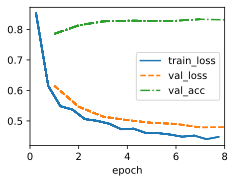

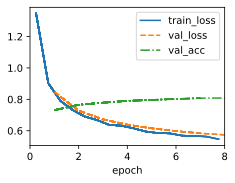

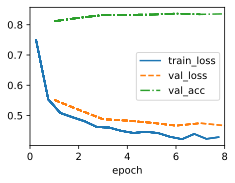

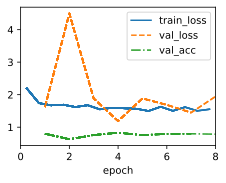

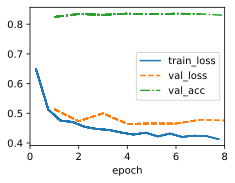

In [5]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f"    validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)

The best learning rate is then simply the one with the lowest validation error.


In [6]:
best_idx = np.argmin(errors)
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.016141431491322293


Due to its simplicity and generality, random search is one of the most frequently
used HPO algorithms. It doesn't require any sophisticated implementation and
can be applied to any configuration space as long as we can define some
probability distribution for each hyperparameter.

Unfortunately random search also comes with a few shortcomings. First, it does
not adapt the sampling distribution based on the previous observations it
collected so far. Hence, it is equally likely to sample a poorly performing
configuration than a better performing configuration. Second, the same amount
of resources are spent for all configurations, even though some may show poor
initial performance and are less likely to outperform previously seen
configurations.

In the next sections we will look at more sample efficient hyperparameter
optimization algorithms that overcome the shortcomings of random search by
using a model to guide the search. We will also look at algorithms that
automatically stop the evaluation process of poorly performing configurations
to speed up the optimization process.

## Summary

In this section we introduced hyperparameter optimization (HPO) and how we can
phrase it as a global optimization by defining a configuration space and an
objective function. We also implemented our first HPO algorithm, random search,
and applied it on a simple softmax classification problem.

While random search is very simple, it is the better alternative to grid
search, which simply evaluates a fixed set of hyperparameters. Random search
somewhat mitigates the curse of dimensionality :cite:`bellman-science66`, and
can be far more efficient than grid search if the criterion most strongly
depends on a small subset of the hyperparameters.

## Exercises

1. In this chapter, we optimize the validation error of a model after training on a disjoint training set. For simplicity, our code uses `Trainer.val_dataloader`, which maps to a loader around `FashionMNIST.val`.
    1. Convince yourself (by looking at the code) that this means we use the original FashionMNIST training set (60000 examples) for training, and the original *test set* (10000 examples) for validation.
    2. Why could this practice be problematic? Hint: Re-read :numref:`sec_generalization_basics`, especially about *model selection*.
    3. What should we have done instead?
2. We stated above that hyperparameter optimization by gradient descent is very hard to do. Consider a small problem, such as training a two-layer perceptron on the FashionMNIST dataset (:numref:`sec_mlp-implementation`) with a batch size of 256. We would like to tune the learning rate of SGD in order to minimize a validation metric after one epoch of training.
    1. Why cannot we use validation *error* for this purpose? What metric on the validation set would you use?
    2. Sketch (roughly) the computational graph of the validation metric after training for one epoch. You may assume that initial weights and hyperparameters (such as learning rate) are input nodes to this graph. Hint: Re-read about computational graphs in :numref:`sec_backprop`.
    3. Give a rough estimate of the number of floating point values you need to store during a forward pass on this graph. Hint: FashionMNIST has 60000 cases. Assume the required memory is dominated by the activations after each layer, and look up the layer widths in :numref:`sec_mlp-implementation`.
    5. Apart from the sheer amount of compute and storage required, what other issues would gradient-based hyperparameter optimization run into? Hint: Re-read about vanishing and exploding gradients in :numref:`sec_numerical_stability`.
    6. *Advanced*: Read :cite:`maclaurin-icml15` for an elegant (yet still somewhat unpractical) approach to gradient-based HPO.
3. Grid search is another HPO baseline, where we define an equi-spaced grid for each hyperparameter, then iterate over the (combinatorial) Cartesian product in order to suggest configurations.
    1. We stated above that random search can be much more efficient than grid search for HPO on a sizable number of hyperparameters, if the criterion most strongly depends on a small subset of the hyperparameters. Why is this? Hint: Read :cite:`bergstra-nips11`.


[Discussions](https://discuss.d2l.ai/t/12090)
